In [ ]:
# Keras classifier with single logistic node for binary classification

In [5]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pickle
import time

from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer, one_hot, text_to_word_sequence
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.models import load_model

#from keras.utils.visualize_util import plot  # deprecated
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [6]:
# Functions

def get_word2index(texts_ls_):
    word2index_ = {}

    c = 1
    for text_str in texts_ls_:
        text_tokens_ls = text_str.lower().split()
        for token in text_tokens_ls:
            if(token not in word2index_):
                word2index_[token] = c
                c = c + 1
                
    return word2index_

def train_df_preprocess(top_words_, texts_ls_, max_pad_length_):
    # texts_ls_: list of texts strings
    
    tok = Tokenizer(top_words_)
    tok.fit_on_texts(texts_ls_)

    words = []
    for iter in range(top_words):
        words += [key for key,value in tok.word_index.items() if value==iter+1]

    #Class for vectorizing texts, or/and turning texts into sequences 
    #(=list of word indexes, where the word of rank i in the dataset (starting at 1) has index i).
    texts_vec_ls = tok.texts_to_sequences(texts_ls_)#turns text to sequence, stating which word comes in what place
    texts_vec_mtx = sequence.pad_sequences(texts_vec_ls, maxlen=max_pad_length_)#pad sequence, essentially padding it with 0's at the end
    
    return texts_vec_mtx

def text_2_vec(text_str, word2index_):
    # text_str: text string
    
    text_tokens_ls = text_str.lower().split()
    
    text_vec = []
    for token in text_tokens_ls:
        if token in word2index_:
            text_vec.append(word2index_[token])
        else:
            text_vec.append(0)
            
    return text_vec

def train_df_preprocess_2(texts_ls_, word2index_, max_pad_length_):
    # texts_ls_: list of texts strings
    
    texts_vec_ls = []
    for text_ in texts_ls_:
        #print(text_)
        #print(type(text_))
        text_vec = text_2_vec(text_, word2index_)
        texts_vec_ls.append(text_vec)
    
    texts_vec_ary = sequence.pad_sequences(texts_vec_ls, maxlen=max_pad_length_)
    
    return texts_vec_ary

def texts_to_sequences_custom(texts_ls, word_index_):
    texts_seq = []
    
    for text in texts_ls:
        text_split = text.lower().split()
        seq = []
        for token in text_split:
            if(token in word_index_):
                seq.append(word_index_[token])
            else:
                seq.append(0)
                
        texts_seq.append(seq)
#         for k,v in word_index_.items():
#             if(v == 395):
#                 print(k,v)
    return texts_seq


def get_model_file_aux(model_file_aux_name):
    with open(model_file_aux_name, 'rb') as pickle_file:
        model_file_aux = pickle.load(pickle_file)
    return model_file_aux

In [7]:
# Read train set (screwdrivers)
pkl_file = '/Users/altay.amanbay/Desktop/new node booster/experiments/3a.1 - Nets train/train_data.pkl'
train_df = pd.read_pickle(pkl_file)

# Create target feature
train_df['target'] = train_df['type'].apply(lambda x: 'False' if x == 'False Positive' else 'Positive')

# Drop index column
train_df.drop(labels=['type'], axis=1, inplace=True)

# Encode target feature
#le = LabelEncoder()
#le.fit(train_df['target'])
#train_df['target_le'] = le.transform(train_df['target'])


# cat = 'Tools & Home Improvement > Power & Hand Tools > Hand Tools > Screwdrivers'
# positives, negatives = get_positives_negatives(train_df, cat)
# X_train = input_text = pd.concat([positives, negatives])
# y_train = [1] * len(positives) + [0] * len(negatives)

print('train data shape:',train_df.shape)
train_df.head(2)

train data shape: (6822, 4)


,description_mod1,category_id_mod1,category_full_path_mod1,target
0,RION TECH 5 point 6 point 3 Piece Tool Kit Pen...,927,Tools & Home Improvement > Power & Hand Tools ...,Positive
1,Stalwart 25-piece 4.8V Cordless Screwdriver Set,927,Tools & Home Improvement > Power & Hand Tools ...,False


In [11]:
# Read sampled descriptionary

path = '/Users/altay.amanbay/Desktop/new node booster/experiments/train data from descriptionary nodes by sampling/3 - Picking samples from each node/sampled descriptionary/'
file_name = 'sampled_descriptionary_sample_size_5000.csv'
samples_df = pd.read_csv(path + file_name)

# Rename columns
samples_df.rename(columns={'description': 'description_mod1', 
                           'category_id': 'category_id_mod1',
                           'category_path': 'category_full_path_mod1'}, inplace=True)

# Drop 'screwdrivers' from descriptionary
samples_df = samples_df.loc[samples_df.category_id_mod1 != 927,:]

# Drop index column
samples_df.drop(labels=['index'], axis=1, inplace=True)

# Add target column and make all false as all items are not screwdrivers
samples_df['target'] = 'False'

print('samples data shape:',samples_df.shape)
samples_df.head()

samples data shape: (951776, 4)


,description_mod1,category_id_mod1,category_full_path_mod1,target
0,!iT Jeans Maternity Skinny Jeans Dark Wash M,100,Apparel & Accessories > Apparel > Maternity,False
1,1822 Denim 'Butter' Maternity Skinny Jeans Rin...,100,Apparel & Accessories > Apparel > Maternity,False
2,25 J Brand Maternity Skinny Jean nirvana blue,100,Apparel & Accessories > Apparel > Maternity,False
3,26 J Brand Maternity Skinny Jean nirvana blue,100,Apparel & Accessories > Apparel > Maternity,False
4,26 James Jeans Maternity Skinny External Mater...,100,Apparel & Accessories > Apparel > Maternity,False


In [12]:
# Concat original train set and sampled descriptionary
train_df = pd.concat([train_df, samples_df], axis=0)
train_df.reset_index(drop=True, inplace=True)

# Encode target feature
le = LabelEncoder()
le.fit(train_df['target'])
train_df['target_le'] = le.transform(train_df['target'])


print('train data shape:',train_df.shape)
train_df.head(2)

train data shape: (958598, 5)


,description_mod1,category_id_mod1,category_full_path_mod1,target,target_le
0,RION TECH 5 point 6 point 3 Piece Tool Kit Pen...,927,Tools & Home Improvement > Power & Hand Tools ...,Positive,1
1,Stalwart 25-piece 4.8V Cordless Screwdriver Set,927,Tools & Home Improvement > Power & Hand Tools ...,False,0


In [13]:
# Split into train and test
#X = train_df.loc[:,['description_mod1']]
X_ls = np.array(list(train_df['description_mod1']))
y_ary = np.array(list(train_df['target_le']))
# X_ls = train_df[['description_mod1']]
# y_ary = train_df[['target_le']]

print(type(X_ls))
print(type(y_ary))

X_train_ls, X_test_ls, y_train_ary, y_test_ary = train_test_split(X_ls, y_ary, test_size = 0.3)

# print(X_train_df.shape)
# print(X_test_df.shape)
print(len(X_train_ls))
print(len(X_test_ls))
print(y_train_ary.shape)
print(y_test_ary.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
671018
287580
(671018,)
(287580,)


In [8]:
# Convert train set into sequences for nets

top_words = 200000
max_description_length = 30

tok = Tokenizer(nb_words = top_words)
tok.fit_on_texts(X_train_ls)
word_index = tok.word_index
print('word_index size:',len(word_index))

#train_texts_vec_ls = tok.texts_to_sequences(X_train_ls)
train_texts_vec_ls = texts_to_sequences_custom(X_train_ls, word_index)
train_texts_vec_mtx = sequence.pad_sequences(train_texts_vec_ls, maxlen = max_description_length)

print('train_texts_vec_mtx shape:',train_texts_vec_mtx.shape)
list(tok.word_index)[0:5]

word_index size: 160138
train_texts_vec_mtx shape: (671018, 30)


['alod', 'winders™', '32802985', 'measurer', 'grapenuts']

In [9]:
# Convert test set into sequences for nets

#test_texts_vec_ls = tok.texts_to_sequences(X_test_ls)
test_texts_vec_ls = texts_to_sequences_custom(X_test_ls, word_index)
test_texts_vec_mtx = sequence.pad_sequences(test_texts_vec_ls, maxlen = max_description_length)

In [11]:
# Create RANDOM embedding vectors for each word in word index (lower cell code preferable)
# fix random seed for reproducibility
np.random.seed(7)

embedding_vecor_length = 32 #32
uniq_token_count = len(tok.word_index)
print('word index size:', uniq_token_count)

embedding_matrix = np.zeros((len(word_index) + 1, embedding_vecor_length))
for word, i in word_index.items():
    embedding_vector = np.random.uniform(.1, size=(1, embedding_vecor_length))
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print('embedding matrix shape:',embedding_matrix.shape)
print(embedding_matrix[0])
print(embedding_matrix[1])

word index size: 77404
embedding matrix shape: (77405, 32)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.27770816  0.81671177  0.21301468  0.94154113  0.39377092  0.891082
  0.29541817  0.35896707  0.66954954  0.50907603  0.11077037  0.81984594
  0.63772684  0.42282534  0.51834815  0.37013495  0.15623341  0.24809457
  0.54476132  0.31239479  0.25101598  0.12233844  0.42003582  0.40615799
  0.12832855  0.32709863  0.61099598  0.37799214  0.53473519  0.8166088
  0.14262626  0.89797792]


In [11]:
## Create word embeddings from trained Word2Vec model
from gensim.models import word2vec, Phrases

# Load model
file_path = '/Users/altay.amanbay/Desktop/word2vec/word2vect_vec64_win3__dict_sample_5000'
model = word2vec.Word2Vec.load(file_path)

#print(model.vocab.keys())
#sys.exit()

# word vector embeddings from model into dictionary
word2vec_dict={}
for word in model.vocab.keys():
    try:
        word2vec_dict[word]=model[word]
    except:    
        pass
print('Loaded %s word vectors.' % len(word2vec_dict))
    
embedding_vecor_length = len(model[word])
print('embedding_vecor_length:',embedding_vecor_length)


embedding_matrix = np.zeros((len(word_index) + 1, embedding_vecor_length))
for word, i in word_index.items():
    embedding_vector = word2vec_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print('\nembedding matrix shape:',embedding_matrix.shape)
print(embedding_matrix[0]) # first cell should be all zeros
print(embedding_matrix[1])

Loaded 27369 word vectors.
embedding_vecor_length: 64

embedding matrix shape: (160139, 64)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-0.11874384 -0.18338123 -0.1189863   0.0296769  -0.10040731  0.19030495
  0.04485871 -0.25051293  0.17562355  0.20848943 -0.12377688 -0.20985943
  0.13807371 -0.13637935  0.02424677  0.06837706  0.06524271 -0.00508871
 -0.02461083 -0.08833824 -0.16471682 -0.03245933 -0.11193646  0.08134902
  0.23003449  0.15979894  0.161314   -0.01001965 -0.25643814 -0.02541378
 -0.02158204 -0.16852614 -0.0245541   0.0272678  -0.08373841  0.00394543
  0.13927533 -0.19923402 -0.00737857  0.11337322 -0.12939563  0.27020159
 -0.07885345 -0.12451541 -0.02593904 -0.09407372  0.04657621 -0.12356172
  0.06735924  0.07370111  0.1704063  -0.19690731 -0.13407005 -0

In [12]:
# Best model result holder
best_model_aux = {}
best_model_aux['Max length'] = max_description_length
best_model_aux['Best Score'] = 0
best_model_aux['Category ID'] = 927
best_model_aux['Category name'] = 'Tools & Home Improvement > Power & Hand Tools > Hand Tools > Screwdrivers'
best_model_aux['Tokenizer'] = tok

best_model = None

In [43]:
# Optional
# Load previous model (if needs to be compared in the following training)
#best_model = load_model('category_927_nets_1000_model.h5')
#best_model_aux = get_model_file_aux('category_927_nets_1000_model_aux.pkl')

In [13]:
best_model_aux['Best Score']

0

In [14]:
# TRAIN MODEL
start = time.time()

# define/initialize model
top_words = len(word_index) + 1
batch_size_ = 64   # 64

model = Sequential()
#model.add(Embedding(top_words, embedding_vecor_length, input_length = max_description_length))
embedding_layer = Embedding(top_words, 
                            embedding_vecor_length, 
                            weights=[embedding_matrix], 
                            input_length = max_description_length,
                            trainable=False)
model.add(embedding_layer)
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
#model.layers[0].trainable = False
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# start training multiple times with epoch=1
for ep in range(1,11):
    #model.fit(X_train_ary, y_train_ary, validation_data=(X_train_ary, y_train_ary), nb_epoch=5, batch_size=64)
    model.fit(train_texts_vec_mtx, y_train_ary, validation_data=(test_texts_vec_mtx, y_test_ary), nb_epoch=1, batch_size=batch_size_)
    
    scores = model.evaluate(test_texts_vec_mtx, y_test_ary, verbose=0)
    if(best_model_aux['Best Score'] < scores[1]):
        best_model_aux['Best Score'] = scores[1]
        best_model = model
        print('Captured improved model')
        #print("Accuracy on test set: %.2f%%" % (scores[1]*100))
    print()
 

print("Training took %g s" % (time.time() - start))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 30, 64)        10248896    embedding_input_1[0][0]          
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 100)           66000       embedding_1[0][0]                
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1)             101         lstm_1[0][0]                     
Total params: 10,314,997
Trainable params: 66,101
Non-trainable params: 10,248,896
____________________________________________________________________________________________________
None
Train on 671018 samples, validate on 287580 samples
Epoch 1/1
671018/671018 [===========================

In [15]:
best_model_aux['Best Score']

0.99931149593156687

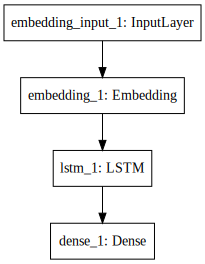

In [29]:
# Plot Nets design
#plot(model, to_file='/Users/altay.amanbay/Desktop/model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [16]:
# Save model and aux file

best_model.save('category_927_nets__traindata5000_vectrain5000_model.h5')

best_model_aux_name = 'category_' + str(best_model_aux['Category ID']) + '_nets__traindata5000_vectrain5000_aux.pkl'
with open(best_model_aux_name, 'wb') as pickle_file:
    pickle.dump(best_model_aux, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

### Evaluation (optional)

In [17]:
# Final evaluation of the model
start = time.time()

scores = model.evaluate(train_texts_vec_mtx, y_train_ary, verbose=0)
print("Accuracy on train set: %.2f%%" % (scores[1]*100))
scores = model.evaluate(test_texts_vec_mtx, y_test_ary, verbose=0)
print("Accuracy on test set: %.2f%%" % (scores[1]*100))

print("Evaluation took %g s" % (time.time() - start))

Accuracy on train set: 99.96%
Accuracy on test set: 99.92%


In [18]:
start = time.time()

predictions = model.predict(test_texts_vec_mtx)
predictions_rnd = np.round_(predictions, decimals=0, out=None)

print("Prediction took %g s" % (time.time() - start))

Prediction took 99.7979 s


In [19]:
#pd.crosstab(pd.Series(y_train_ary.ravel()), pd.Series(predictions_rnd.ravel()), rownames=['True'], colnames=['Predicted'], margins=True)
pd.crosstab(pd.Series(y_test_ary.ravel()), pd.Series(predictions_rnd.ravel()), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0,285928,47,285975
1,196,1409,1605
All,286124,1456,287580


In [58]:
pd.crosstab(pd.Series(y_test_ary.ravel()), pd.Series(predictions_rnd.ravel()), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0,78363,103,78466
1,102,1493,1595
All,78465,1596,80061


### Testing

In [12]:
#model.get_config()
def prediction_to_str(clf_prediction, category_id):
    if(clf_prediction > 0.5):
        return str(category_id)
    else:
        return 'not ' + str(category_id)

def predict(description_str, tok_, clf_, max_length_, category_id_):
    #seq_ = tok_.texts_to_sequences([description_str])
    seq_ = texts_to_sequences_custom([description_str.lower()], word_index_)
    seq_pad = sequence.pad_sequences(seq_, maxlen = max_length_)
    clf_prediction = clf_.predict(seq_pad)
    
    #print(seq_)
    #print(seq_pad)
    
    # Prediction to string
    clf_prediction_str = prediction_to_str(clf_prediction[0][0], category_id_)
    
    return clf_prediction_str
    #return clf_prediction[0][0]

def predict_proba(description_str, tok_, clf_, max_length_):
    #seq_ = tok_.texts_to_sequences([description_str])
    seq_ = texts_to_sequences_custom([description_str], word_index_)
    seq_pad = sequence.pad_sequences(seq_, maxlen = max_length_)
    clf_prediction_proba = clf_.predict_proba(seq_pad, verbose=0)
    
    return clf_prediction_proba[0][0]


# id_ = 'table Setr'
# p = predict(id_, best_model_aux['Tokenizer'], best_model, best_model_aux['Max length'], best_model_aux['Category ID'])
# pp = predict_proba(id_, best_model_aux['Tokenizer'], best_model, best_model_aux['Max length'])
# print(p)
# print(pp)

In [19]:
# TEST

## load old model
model_file = "category_927_nets__traindata5000_vectrain5000_model.h5"
aux_file = "category_927_nets__traindata5000_vectrain5000_aux.pkl"
old_best_model_ = load_model(model_file)
old_best_model_aux_ = get_model_file_aux(aux_file)
old_tok_ = old_best_model_aux_['Tokenizer']
old_word_index_ = old_best_model_aux_['Tokenizer'].word_index

## use fresh model
# best_model_ = best_model
# best_model_aux_ = best_model_aux
# tok_ = tok
# word_index_ = word_index

item_d = 'NieR: Automata™ DEMO 120161128 (Playable Demo)'

# screwdrivers check
scrw_items = [
"tekton 2655 flare nut wrench set metric 6piece"
,"tekton 2780 10slot screwdriver holder and organizer"
,"titan 17237 insulated electrical screwdriver set  7 piece"
,"tool sorter screwdriver organizer red"
,"torin sdh15rt magnetic screwdriver holder"  #wrong predict
,"wera 05020013001 joker combination wrenchset 11 pieces"
,"wera kk vde 60i62i68i18 insulated pouch set with interchangeable blades 18piece" # tricky
,"wiha 28103 magnetic 14 bit holder stubby 57mm pliers screwdriver" # tricky, wrong predict
]

for n, i in enumerate(scrw_items):
    item_d = i
    
    print(str(n) + ' ' + '='*100)
    
    print('Old model prediction:')
    print('item:',item_d)
    print('Seq max len:', old_best_model_aux_['Max length'])
    print(predict(item_d, old_tok_, old_best_model_, old_best_model_aux_['Max length'], '927'))
    print(predict_proba(item_d, old_tok_, old_best_model_, old_best_model_aux_['Max length']))


    print('\nFresh model prediction:')
    print('item:',item_d)
    print('Seq max len:', best_model_aux_['Max length'])
    print(predict(item_d, tok_, best_model_, best_model_aux_['Max length'], '927'))
    print(predict_proba(item_d, tok_, best_model_, best_model_aux_['Max length']))

    print()

    #tt = train_df.loc[0:10,['description_mod1']]
    #tt['pred'] = tt['description_mod1'].apply(lambda x: predict(x, best_model_aux_['Tokenizer'], best_model, best_model_aux_['Max length'], best_model_aux_['Category ID']))
    #tt['prob'] = tt['description_mod1'].apply(lambda x: predict_proba(x, best_model_aux_['Tokenizer'], best_model, best_model_aux_['Max length']))

0 ====================================================================================================
Old model prediction:
item: tekton 2655 flare nut wrench set metric 6piece
Seq max len: 30
not 927
4.17323e-08

Fresh model prediction:
item: tekton 2655 flare nut wrench set metric 6piece
Seq max len: 30
not 927
4.17323e-08

1 ====================================================================================================
Old model prediction:
item: tekton 2780 10slot screwdriver holder and organizer
Seq max len: 30
not 927
0.121584

Fresh model prediction:
item: tekton 2780 10slot screwdriver holder and organizer
Seq max len: 30
not 927
0.121584

2 ====================================================================================================
Old model prediction:
item: titan 17237 insulated electrical screwdriver set  7 piece
Seq max len: 30
927
0.998989

Fresh model prediction:
item: titan 17237 insulated electrical screwdriver set  7 piece
Seq max len: 30
927
0.998989

3